# Actividad: 2.5.1 Clasificación de imágenes con redes neuronales convolucionales
# Ejercicio 2

Ejercicio 2 

Para el conjunto de datos de German Traffic Sign Recognition BenchmarkLinks to an external site. (GTSRB) (problema de clasificación de mas de 40 clases), ajuste una red neuronal convolucional y evalúe su rendimiento con validación cruzada. Reporta los problemas a los que te enfrentaste para obtener tu modelo.

## Sección 1: Instalación e imports

Preparación del entorno con las bibliotecas necesarias.

In [50]:
# ————————————————————————
# 0. Instalación e imports
# ————————————————————————
import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay

from skimage.feature import hog
from skimage import exposure

import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


##  Sección 1: Contexto teórico breve

Este notebook combina dos enfoques:

1. Extracción de características clásicas (HOG) con SVM.

2. Modelado profundo usando una red neuronal convolucional (CNN).

Además se visualizan agrupamientos con PCA y t-SNE.


## Sección 2: Carga de imágenes y etiquetas (43 clases)



In [51]:
# ————————————————————————
# 2. Carga de imágenes y etiquetas (43 clases)
# ————————————————————————
IMG_DIM = 128
DATASET_DIR = "/home/brunene/Documents/ITESM/Robotica inteligente/Módulo 2 - Visión computacional (Prof. Cesar)/semana8/FullIJCNN2013"  # Ajusta si es necesario

CLASS_NAMES = {
    0: 'speed limit 20', 1: 'speed limit 30', 2: 'speed limit 50', 3: 'speed limit 60',
    4: 'speed limit 70', 5: 'speed limit 80', 6: 'restriction ends 80', 7: 'speed limit 100',
    8: 'speed limit 120', 9: 'no overtaking', 10: 'no overtaking trucks',
    11: 'priority at intersection', 12: 'priority road', 13: 'give way', 14: 'stop',
    15: 'no traffic both ways', 16: 'no trucks', 17: 'no entry', 18: 'danger',
    19: 'bend left', 20: 'bend right', 21: 'bend', 22: 'uneven road', 23: 'slippery road',
    24: 'road narrows', 25: 'construction', 26: 'traffic signal', 27: 'pedestrian crossing',
    28: 'school crossing', 29: 'cycles crossing', 30: 'snow', 31: 'animals',
    32: 'restriction ends', 33: 'go right', 34: 'go left', 35: 'go straight',
    36: 'go right or straight', 37: 'go left or straight', 38: 'keep right',
    39: 'keep left', 40: 'roundabout', 41: 'restriction ends overtaking',
    42: 'restriction ends overtaking trucks'
}

images, labels = [], []

for cls_id in range(43):
    cls_dir = os.path.join(DATASET_DIR, f"{cls_id:02}")
    if not os.path.isdir(cls_dir):
        continue
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.ppm', '.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cls_dir, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_DIM, IMG_DIM))
            images.append(img)
            labels.append(cls_id)

X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels)
NUM_CLASSES = len(CLASS_NAMES)

print(f"Total imágenes cargadas: {len(X)} — Clases detectadas: {NUM_CLASSES}")


Total imágenes cargadas: 1213 — Clases detectadas: 43


## Sección 3: Visualización y distribución de imagenes por clase

/tmp/ipykernel_6111/632794477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


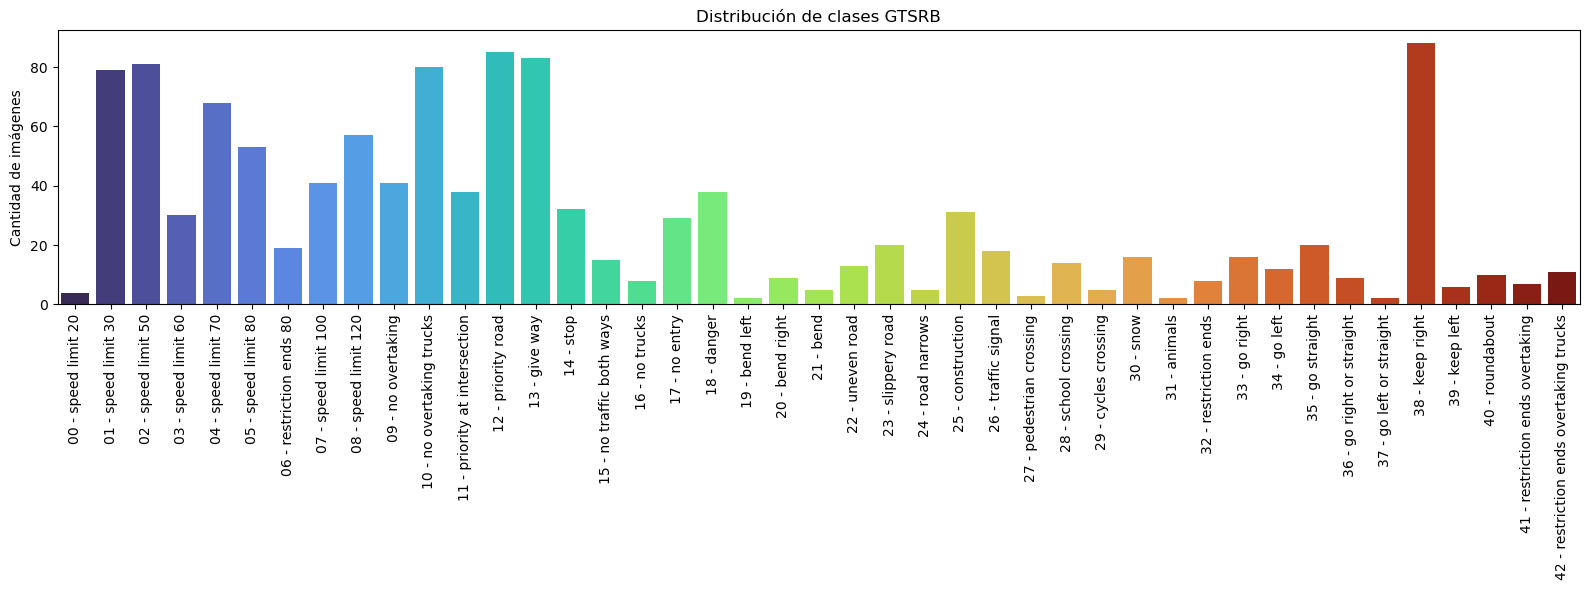

In [52]:
# ————————————————————————
# 3. Distribución de clases
# ————————————————————————
plt.figure(figsize=(16,6))
cnt = Counter(y)
sns.barplot(
    x=[f"{k:02} - {CLASS_NAMES[k]}" for k in cnt.keys()],
    y=list(cnt.values()),
    palette="turbo"
)
plt.title("Distribución de clases GTSRB")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Sección 4: Visualización de ejemplos aleatorios



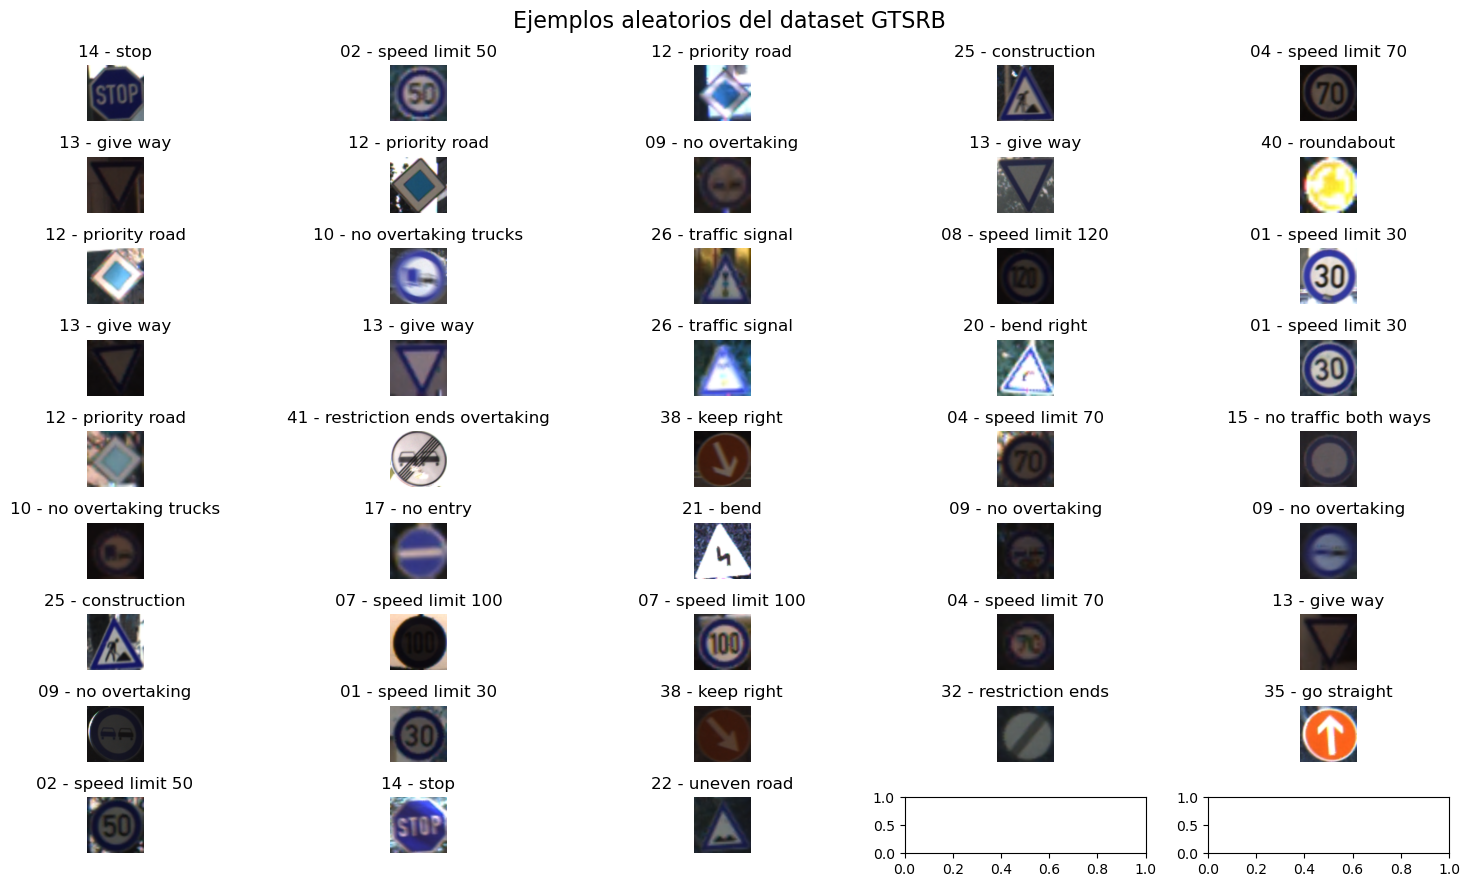

In [53]:
# ————————————————————————
# 4. Muestra de ejemplos visuales
# ————————————————————————
fig, axes = plt.subplots(9, 5, figsize=(15, 9))
indices = np.random.choice(len(X), 43, replace=False)
for ax, idx in zip(axes.flat, indices):
    ax.imshow(X[idx])
    ax.set_title(f"{y[idx]:02} - {CLASS_NAMES[y[idx]]}")
    ax.axis("off")
plt.suptitle("Ejemplos aleatorios del dataset GTSRB", fontsize=16)
plt.tight_layout()
plt.show()


## Sección 5: Extracción de HOG y visualización con PCA y t-SNE

Descripción: Calculamos el descriptor HOG para todas las imágenes, lo convertimos a una matriz y visualizamos los agrupamientos con PCA y t-SNE.




In [54]:
# ————————————————————————
# 5. Extracción de HOG + Visualización PCA y t-SNE
# ————————————————————————
X_gray = np.mean(X, axis=-1)  # Convertimos a escala de grises
X_hog = []

print("Extrayendo descriptores HOG ...")
for img in X_gray:
    hog_vec = hog(
        img, orientations=9,
        pixels_per_cell=(8,8), cells_per_block=(2,2),
        block_norm='L2-Hys'
    )
    X_hog.append(hog_vec)

X_hog = np.array(X_hog)
print("Shape final de la matriz HOG:", X_hog.shape)


Extrayendo descriptores HOG ...
Shape final de la matriz HOG: (1213, 8100)


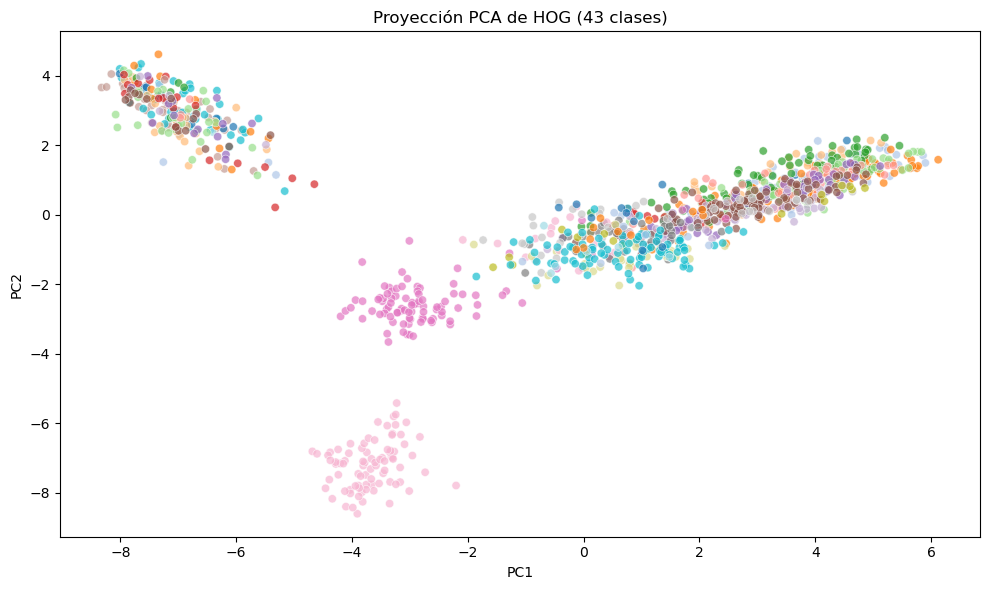

In [55]:
# Visualización con PCA (proyección a 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_hog)

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=[CLASS_NAMES[i] for i in y],
    palette="tab20", legend=False, alpha=0.7
)
plt.title("Proyección PCA de HOG (43 clases)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


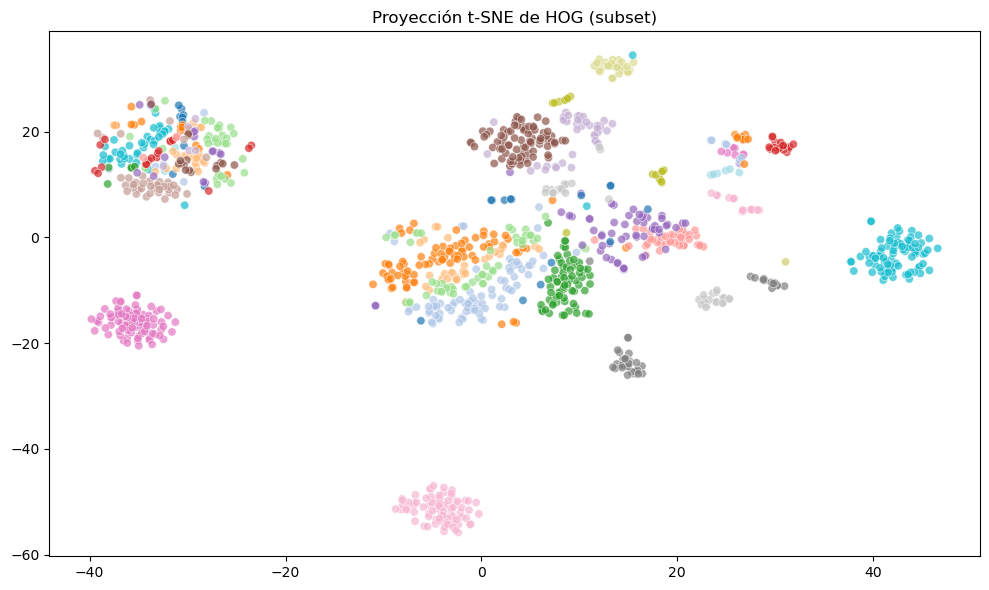

In [56]:
# Visualización t-SNE (con subset por rendimiento)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_hog[:2000])
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=[CLASS_NAMES[i] for i in y[:2000]],
    palette="tab20", legend=False, alpha=0.7
)
plt.title("Proyección t-SNE de HOG (subset)")
plt.tight_layout()
plt.show()


##  Sección 6: Modelo clásico base con HOG + SVM

Descripción: Entrenamos un modelo SVM base usando los descriptores HOG y validación cruzada de 5 pliegues.

In [57]:
# ————————————————————————
# 6. Baseline con HOG + SVM (sin tuning)
# ————————————————————————
svc = SVC(kernel='rbf', gamma='scale', C=10, random_state=42)
scores = cross_val_score(svc, X_hog, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"HOG+SVM baseline 5-fold accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


HOG+SVM baseline 5-fold accuracy: 0.9225 ± 0.0109


## Sección 7: SVM ajustado (tuning) con PCA + RandomizedSearchCV

Descripción: Optimizamos el SVM con un pipeline PCA + búsqueda aleatoria de hiperparámetros.

In [58]:
# ————————————————————————
# 7. SVM ajustado con RandomizedSearchCV
# ————————————————————————
# Submuestreo del 30% para agilizar tuning
X_sub, _, y_sub, _ = train_test_split(
    X_hog, y, train_size=0.3, stratify=y, random_state=42
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__kernel': ['rbf','poly'],
    'svc__C':      np.logspace(-2,2,5),
    'svc__gamma':  np.logspace(-4,-1,5),
    'svc__degree': [2,3]
}

rnd = RandomizedSearchCV(
    pipe, param_dist, n_iter=10,
    cv=3, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)

rnd.fit(X_sub, y_sub)
print("Mejores params:", rnd.best_params_)
print(f"Mejor accuracy (cv): {rnd.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Mejores params: {'svc__kernel': 'rbf', 'svc__gamma': np.float64(0.0001), 'svc__degree': 3, 'svc__C': np.float64(10.0)}
Mejor accuracy (cv): 0.7769


## Sección 8: Evaluación del SVM ajustado

Descripción: Evaluamos el mejor modelo ajustado sobre todo el conjunto de entrenamiento y mostramos la matriz de confusión.

Accuracy en todo el set (modelo ajustado): 0.8928


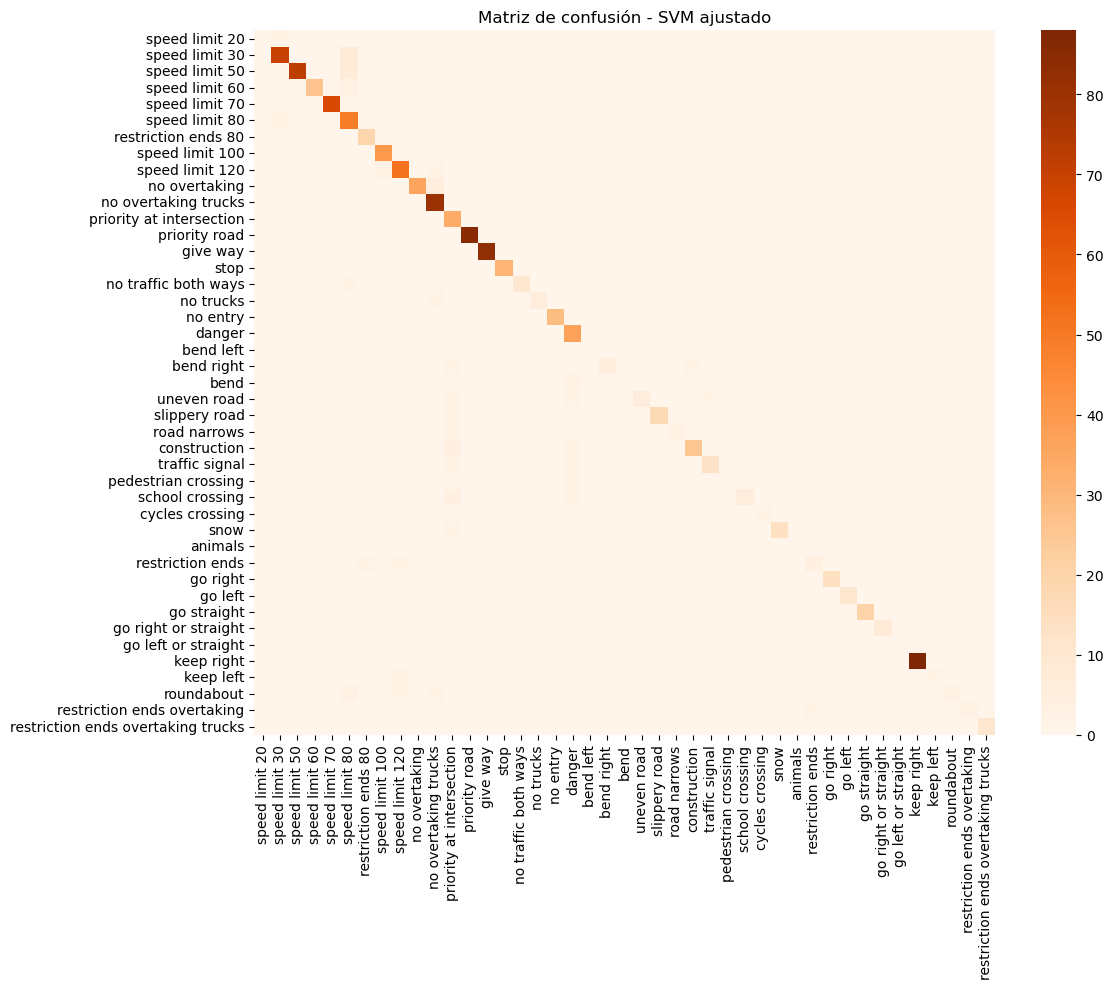

In [59]:
# Evaluación final en todo el set
best_svm = rnd.best_estimator_
y_pred_best = best_svm.predict(X_hog)

acc_final = accuracy_score(y, y_pred_best)
print(f"Accuracy en todo el set (modelo ajustado): {acc_final:.4f}")

# Matriz de confusión
cm = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(12,10))
sns.heatmap(cm, fmt='d', cmap='Oranges',
            xticklabels=list(CLASS_NAMES.values()),
            yticklabels=list(CLASS_NAMES.values()))
plt.title("Matriz de confusión - SVM ajustado")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


## Sección 9: Preparación para entrenamiento CNN

Descripción: Separamos los datos en entrenamiento y validación, con codificación one-hot y aumento de datos (ImageDataGenerator).

In [60]:
# ————————————————————————
# 9. Preparación de datos para CNN
# ————————————————————————
y_cat = to_categorical(y, num_classes=NUM_CLASSES)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=5
)
datagen.fit(X_train)


## Sección 10: Construcción de la CNN y callback de tiempo

Descripción: Definimos la arquitectura CNN y un callback personalizado para medir el tiempo por época.

In [61]:
# ————————————————————————
# 10. Construcción de la CNN y Callback
# ————————————————————————
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_DIM, IMG_DIM, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Callback para medir tiempo
class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.start_time)

cnn = build_cnn()
cnn.summary()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
timing = TimingCallback()


/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,794,667 (98.40 MB)

 Trainable params: 25,794,667 (98.40 MB)

 Non-trainable params: 0 (0.00 B)

## Sección 11: Entrenamiento CNN con Data Augmentation

Descripción: Entrenamos la CNN con el generador de imágenes aumentadas y registramos el tiempo promedio por época.

In [69]:
# ————————————————————————
# 11. Entrenamiento CNN con data augmentation
# ————————————————————————
batch_size = 64
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

history = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[es, timing],
    verbose=1
)

# Tiempo medio por epoch
print(f"⏱️ Tiempo medio por epoch: {np.mean(timing.times):.2f}s ± {np.std(timing.times):.2f}s")


/home/brunene/anaconda3/envs/iatec/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.4728 - loss: 1.6554 - val_accuracy: 0.5597 - val_loss: 1.3970
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - accuracy: 0.4968 - loss: 1.6184 - val_accuracy: 0.5391 - val_loss: 1.4078
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.4944 - loss: 1.6077 - val_accuracy: 0.5309 - val_loss: 1.3662
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.4710 - loss: 1.6337 - val_accuracy: 0.5391 - val_loss: 1.3894
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.5119 - loss: 1.5025 - val_accuracy: 0.5597 - val_loss: 1.3470
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - accuracy: 0.5159 - loss: 1.4981 - val_accuracy: 0.5761 - val_loss: 1.3431
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - accuracy: 0.5076 - loss: 1.4948 - val_accuracy: 0.5802 - val_loss: 1.2679
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.5631 - loss: 1.4001 - val_accuracy: 0.

## Sección 12: Curvas de pérdida y exactitud por época

Descripción: Mostramos gráficamente cómo evolucionó la pérdida y exactitud en entrenamiento y validación.

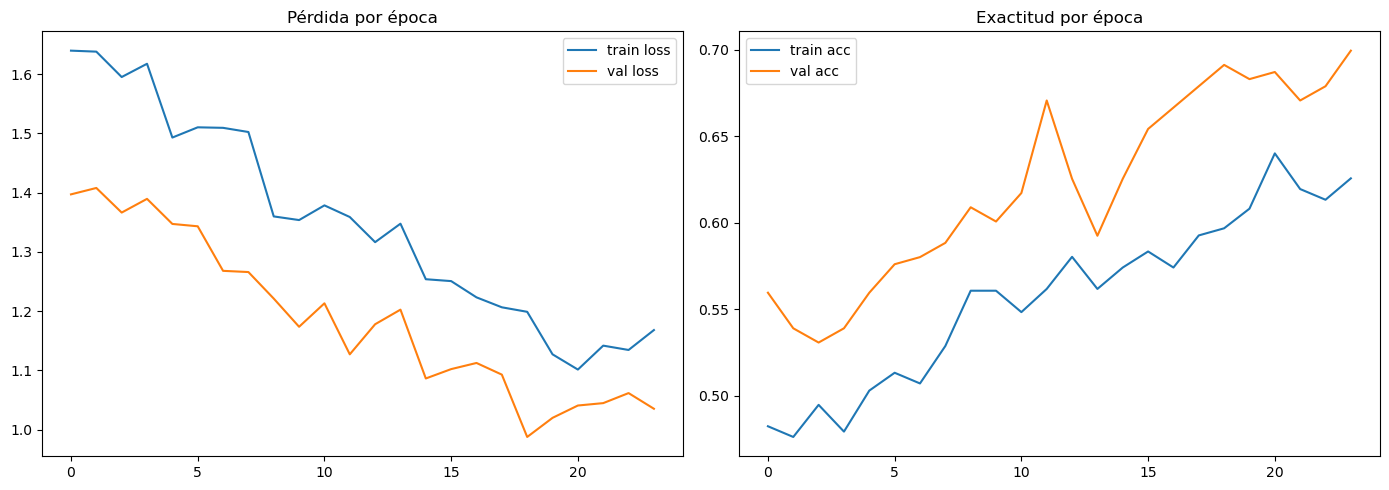

In [70]:
# ————————————————————————
# 12. Curvas de pérdida y accuracy
# ————————————————————————
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

sns.lineplot(data=history.history['loss'], label='train loss', ax=ax1)
sns.lineplot(data=history.history['val_loss'], label='val loss', ax=ax1)
ax1.set_title("Pérdida por época")

sns.lineplot(data=history.history['accuracy'], label='train acc', ax=ax2)
sns.lineplot(data=history.history['val_accuracy'], label='val acc', ax=ax2)
ax2.set_title("Exactitud por época")

plt.tight_layout()
plt.show()


## Sección 13: Evaluación final CNN y análisis de errores

Descripción: Evaluamos el modelo sobre el conjunto de validación y graficamos la matriz de confusión con ejemplos fallidos.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


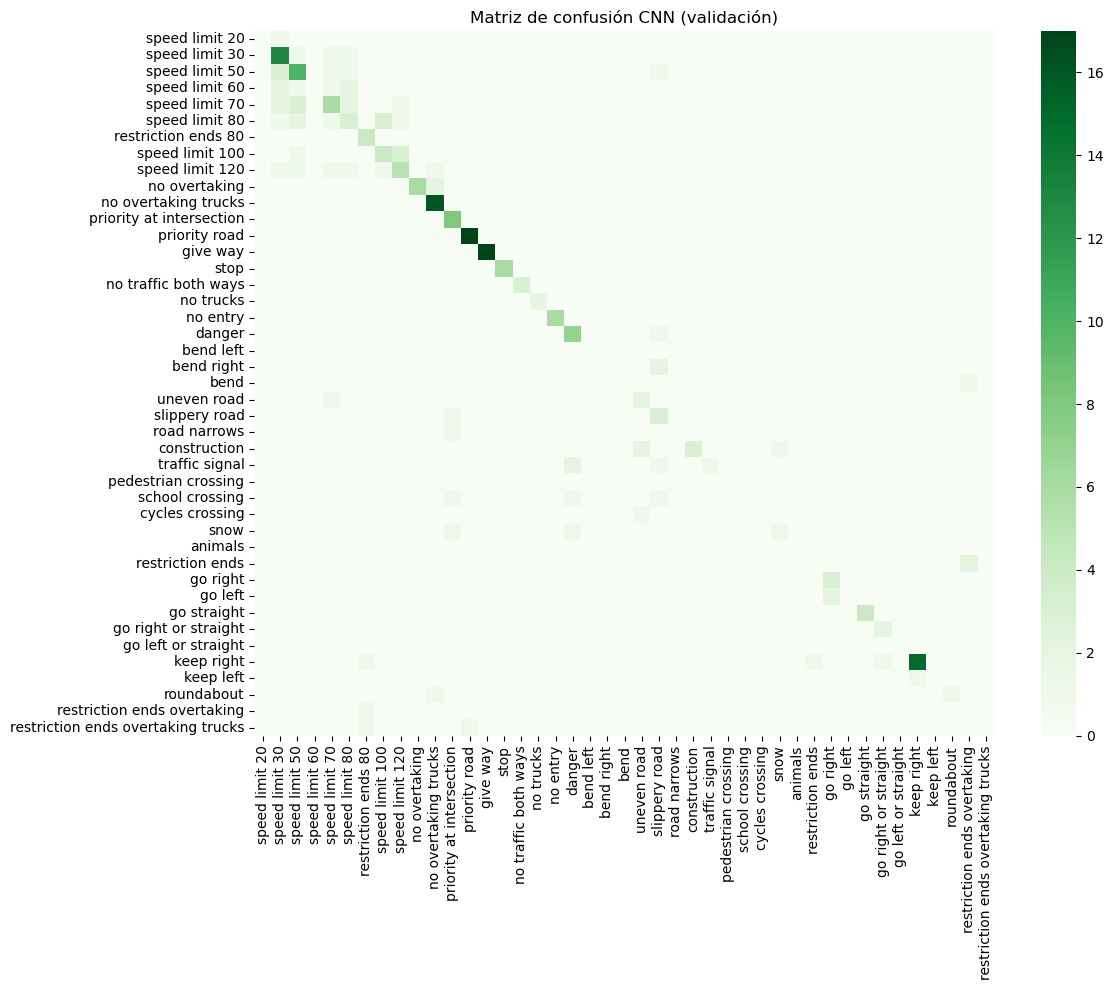

                                    precision    recall  f1-score   support

                    speed limit 20       0.00      0.00      0.00         1
                    speed limit 30       0.57      0.81      0.67        16
                    speed limit 50       0.53      0.62      0.57        16
                    speed limit 60       0.00      0.00      0.00         6
                    speed limit 70       0.50      0.43      0.46        14
                    speed limit 80       0.30      0.27      0.29        11
               restriction ends 80       0.57      1.00      0.73         4
                   speed limit 100       0.50      0.50      0.50         8
                   speed limit 120       0.50      0.45      0.48        11
                     no overtaking       1.00      0.75      0.86         8
              no overtaking trucks       0.80      1.00      0.89        16
          priority at intersection       0.67      1.00      0.80         8
           

In [71]:
# ————————————————————————
# 13. Evaluación final y matriz de confusión
# ————————————————————————
y_pred_val = np.argmax(cnn.predict(X_val), axis=1)
y_true_val = np.argmax(y_val, axis=1)

cm_cnn = confusion_matrix(y_true_val, y_pred_val, labels=range(NUM_CLASSES))
plt.figure(figsize=(12,10))
sns.heatmap(cm_cnn, annot=False, fmt='d', cmap='Greens',
            xticklabels=list(CLASS_NAMES.values()),
            yticklabels=list(CLASS_NAMES.values()))
plt.title("Matriz de confusión CNN (validación)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Se corrige incluyendo labels explícitamente
print(classification_report(
    y_true_val, y_pred_val,
    labels=range(NUM_CLASSES),
    target_names=list(CLASS_NAMES.values()),
    zero_division=0  # evita warnings por clases ausentes
))


## Sección 14: Comparativa de modelos

Descripción: Comparamos la precisión entre HOG+SVM (baseline), SVM ajustado y la CNN.


/tmp/ipykernel_6111/4215648333.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Modelo', y='Accuracy', palette='pastel')


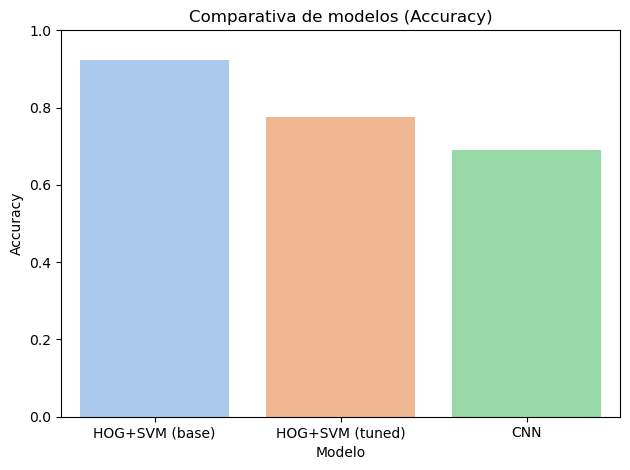

,Modelo,Accuracy
0,HOG+SVM (base),0.922505
1,HOG+SVM (tuned),0.776860
2,CNN,0.691358


In [72]:
# ————————————————————————
# 14. Comparación de modelos
# ————————————————————————
results = pd.DataFrame({
    'Modelo': ['HOG+SVM (base)', 'HOG+SVM (tuned)', 'CNN'],
    'Accuracy': [
        scores.mean(),
        rnd.best_score_,
        accuracy_score(y_true_val, y_pred_val)
    ]
})

sns.barplot(data=results, x='Modelo', y='Accuracy', palette='pastel')
plt.ylim(0,1)
plt.title("Comparativa de modelos (Accuracy)")
plt.tight_layout()
plt.show()

display(results)


## Sección 15: Probabilidad de clase, entre 10 clases entre si



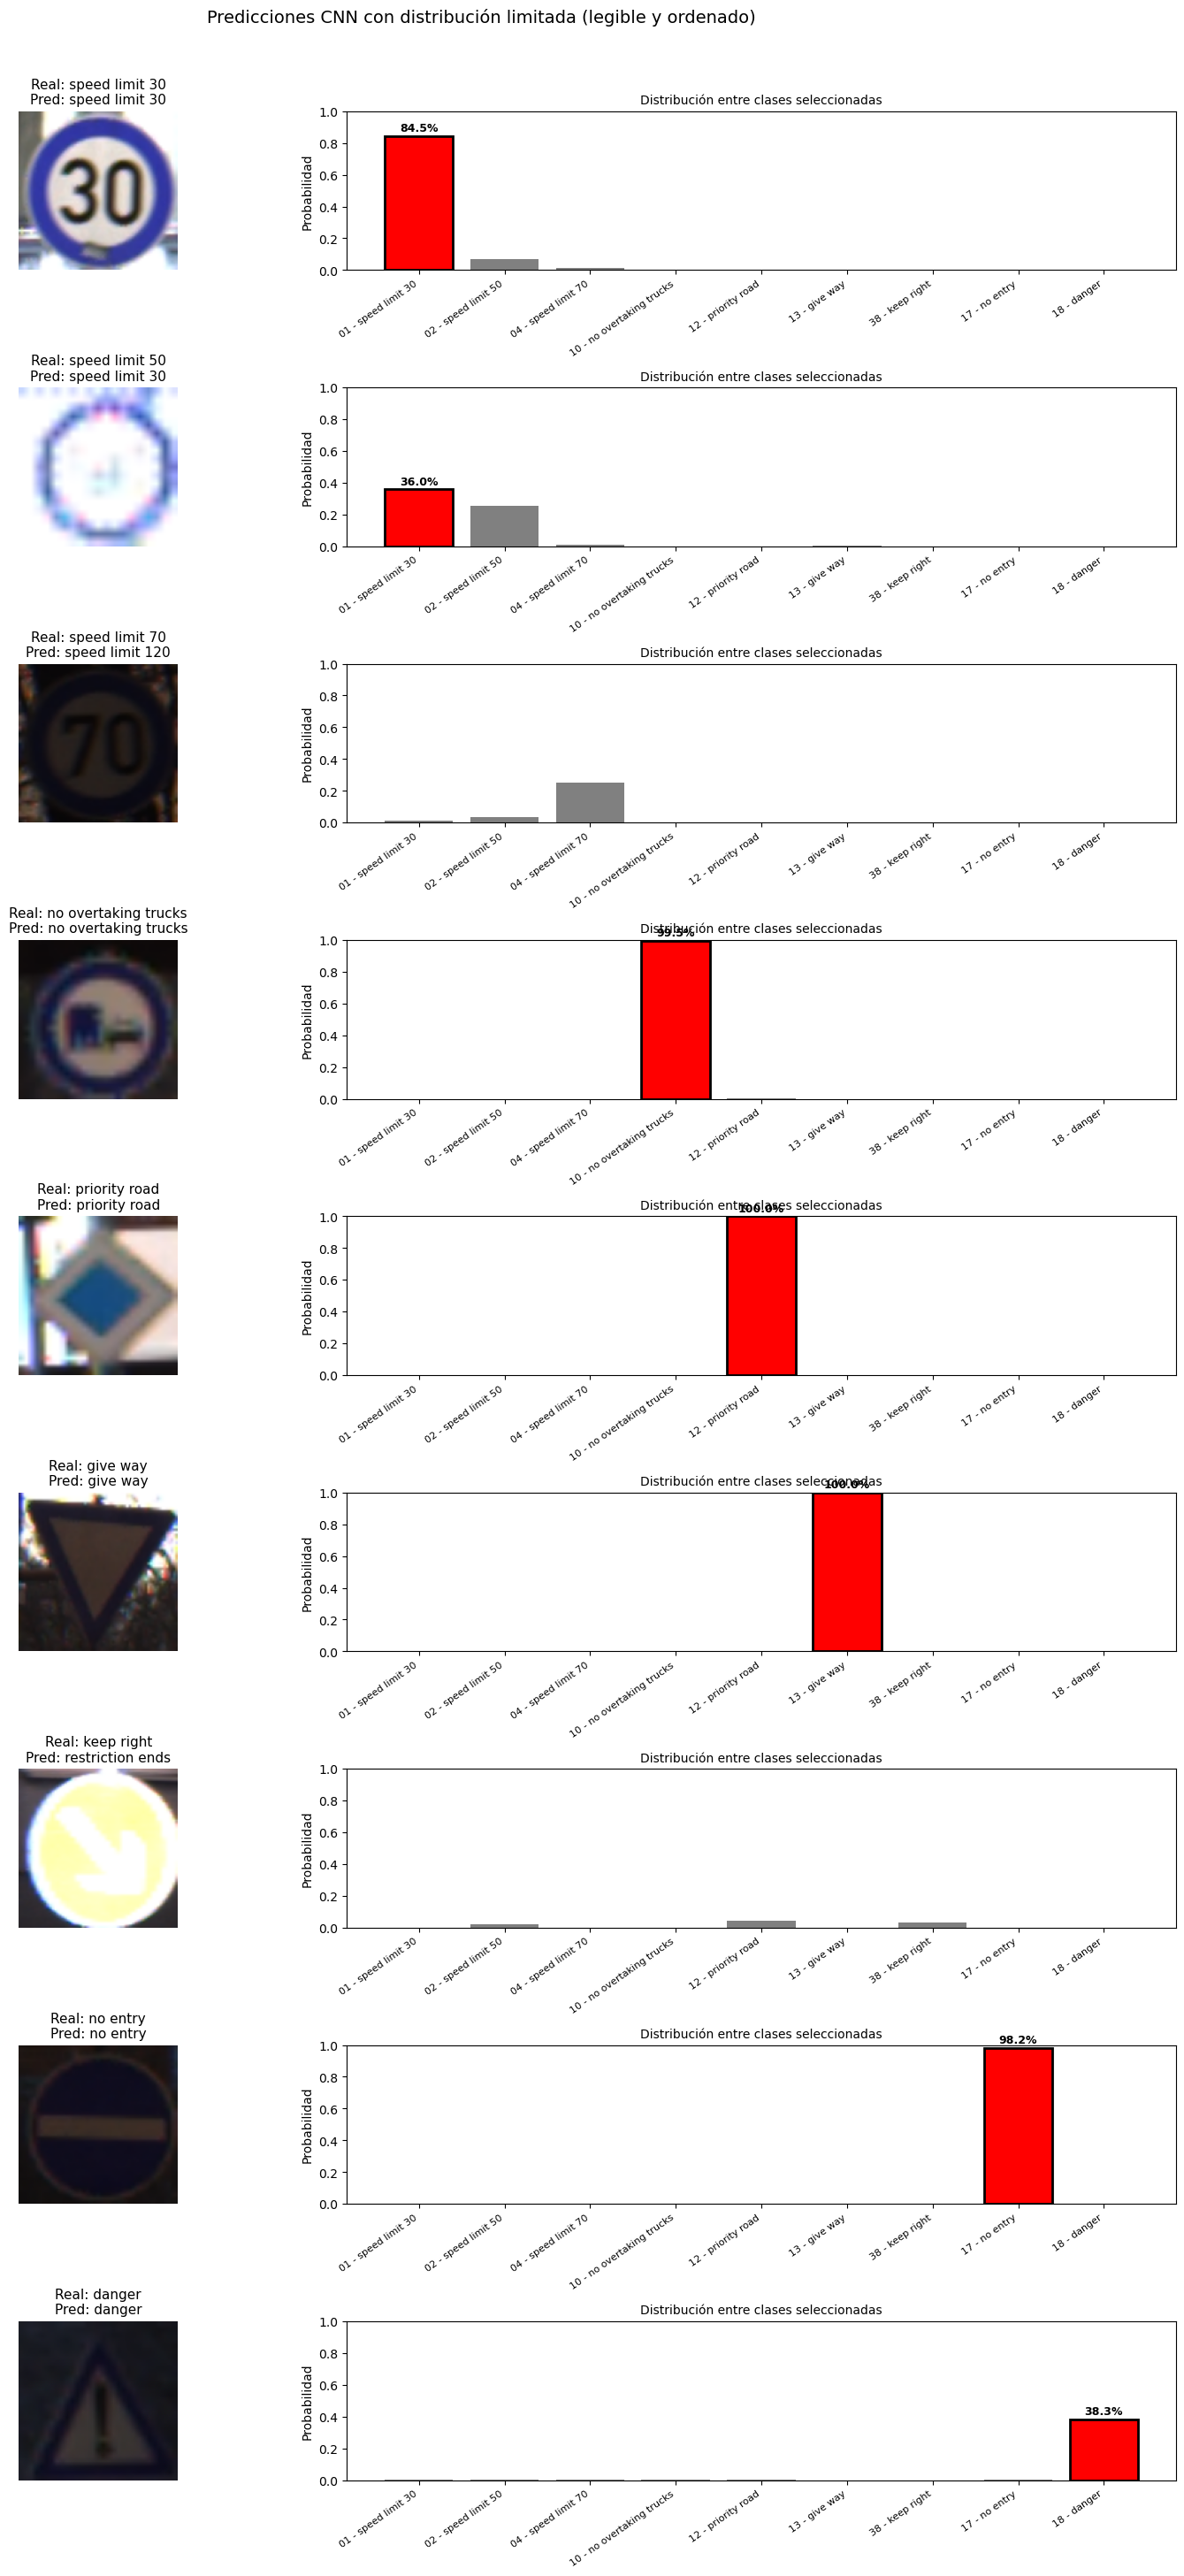

In [77]:
# ————————————————————————————————
# 15. Visualización de ejemplos con distribución (mejorada)
# ————————————————————————————————

# Verificación de variables previas
try:
    probs_val
except NameError:
    probs_val = cnn.predict(X_val)
    y_pred_val = np.argmax(probs_val, axis=1)
    y_true_val = np.argmax(y_val, axis=1)

# Clases seleccionadas
selected_classes = [1, 2, 4, 10, 12, 13, 38, 17, 18]
selected_names   = [CLASS_NAMES[c] for c in selected_classes]
reverse_map = {cls: i for i, cls in enumerate(selected_classes)}
n_sel = len(selected_classes)

# Obtener un ejemplo por clase
example_indices = []
for cls in selected_classes:
    indices = np.where(y_true_val == cls)[0]
    if len(indices) > 0:
        example_indices.append(indices[0])

# Extraer ejemplos
X_examples = X_val[example_indices]
true_labels = [y_true_val[i] for i in example_indices]
pred_labels = [y_pred_val[i] for i in example_indices]
probs_examples = probs_val[example_indices][:, selected_classes]

# Visualización limpia: una fila por ejemplo (imagen + barra)
fig, axes = plt.subplots(len(example_indices), 2, figsize=(16, 3.2 * len(example_indices)),
                         gridspec_kw={'width_ratios': [1.5, 2]})

for row, (img, true, pred, probs) in enumerate(zip(X_examples, true_labels, pred_labels, probs_examples)):
    ax_img, ax_bar = axes[row]

    # Imagen
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title(f"Real: {CLASS_NAMES[true]}\nPred: {CLASS_NAMES[pred]}", fontsize=11)

    # Barra de probabilidad solo con clases seleccionadas
    bars = ax_bar.bar(range(n_sel), probs, color='gray')
    pred_idx = reverse_map.get(pred, None)
    if pred_idx is not None:
        bars[pred_idx].set_color('red')
        bars[pred_idx].set_edgecolor('black')
        bars[pred_idx].set_linewidth(2)
        ax_bar.text(pred_idx, probs[pred_idx] + 0.03,
                    f"{probs[pred_idx]:.1%}", ha='center', fontsize=9, fontweight='bold')

    ax_bar.set_xticks(range(n_sel))
    ax_bar.set_xticklabels([f"{i:02} - {name}" for i, name in zip(selected_classes, selected_names)],
                           rotation=35, ha='right', fontsize=8)
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probabilidad")
    ax_bar.set_title("Distribución entre clases seleccionadas", fontsize=10)

plt.suptitle("Predicciones CNN con distribución limitada (legible y ordenado)", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()
